In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

import nengo
from nengo.utils.matplotlib import rasterplot
from nengo.dists import Uniform
from nengo.processes import WhiteSignal
from nengo.processes import Piecewise
from IPython.display import HTML

import nengo_loihi

import pandas as pd

In [2]:
model = nengo.Network(label="Multidirectional Nav Dynamics")
with model:
    # Create the recurrent neuron ensemble
    D = nengo.Ensemble(400, dimensions=6)

    # Create piecewise acceleration control input
    # Note, I am initializing BOTH directions as the exact same dynamics from the past two parts
    # That way, you can confirm everything is connected properly first
    # inputs = [[.5, .5], [0, 0], [-1, -1], [0, 0], [1, 1], [0,0]]
    inputs = [
        [0, 0.5],
        [0, -0.5],
        [0.5, 0],
        [-0.5, 0],
        [0, -0.5],
        [0, 0.5],
        [0.5, 0],
        [-0.5, 0],
    ]
    #          [north],  [brakes], [east] , [brakes], [south], [brakes], [east], [brakes]
    process = nengo.processes.PresentInput(inputs, presentation_time=1)
    accel_input = nengo.Node(process)

    # input_accelX = nengo.Node(Piecewise({0: 0, 0.2: 1, 1: 0, 2: -2, 3: 0, 4: 1, 5: 0}))
    # input_accelY = nengo.Node(Piecewise({0: 0, 0.2: 1, 1: 0, 2: -2, 3: 0, 4: 1, 5: 0}))

    # Using a long time constant for stability (less noise)
    tau = 0.8

    feedback_matrix = [
        [1, 0, tau, 0, 0, 0],
        [0, 1, 0, tau, 0, 0],
        [0, 0, 1, 0, tau, 0],
        [0, 0, 0, 1, 0, tau],
        [0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 1],
    ]
    print(feedback_matrix)
    nengo.Connection(D, D, transform=feedback_matrix, synapse=tau)

    feedfwd_matrix = [[0, 0], [0, 0], [0, 0], [0, 0], [tau, 0], [0, tau]]
    # print(feedfwd_matrix)

    nengo.Connection(accel_input, D, transform=feedfwd_matrix, synapse=tau)

[[1, 0, 0.8, 0, 0, 0], [0, 1, 0, 0.8, 0, 0], [0, 0, 1, 0, 0.8, 0], [0, 0, 0, 1, 0, 0.8], [0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 1]]


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

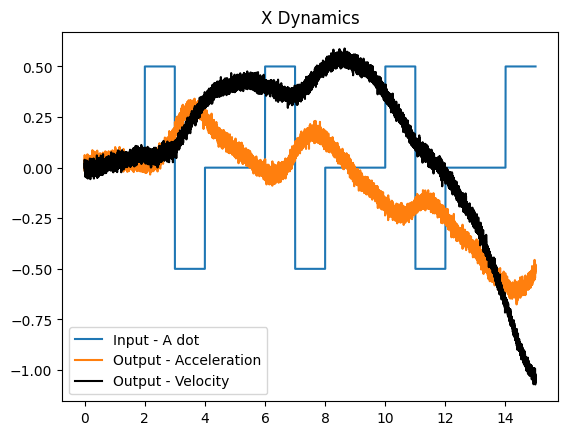

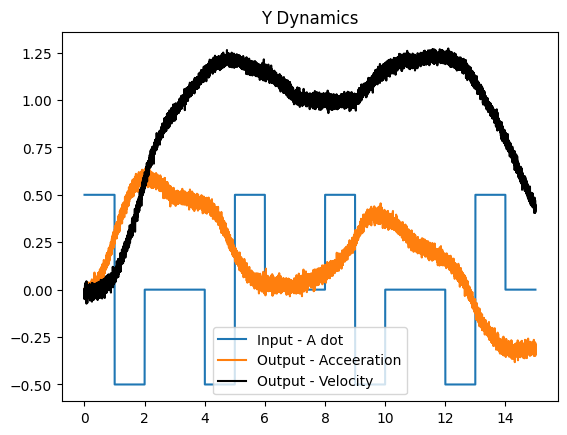

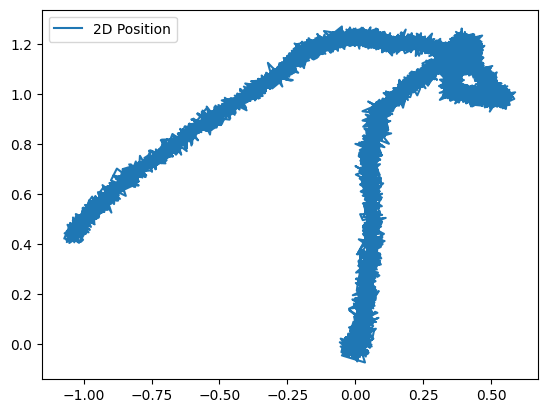

In [3]:
with model:
    # Probe and run
    # Add probes
    input_probe = nengo.Probe(accel_input)
    output_probe = nengo.Probe(D, synapse=0.01)

# Create our simulator
with nengo.Simulator(model) as sim:
    # Run it for 10 seconds
    sim.run(15)

plt.figure()
plt.plot(sim.trange(), sim.data[input_probe][:, 0], label="Input - A dot")
plt.plot(sim.trange(), sim.data[output_probe][:, 2], label="Output - Acceleration")
plt.plot(sim.trange(), sim.data[output_probe][:, 0], "k", label="Output - Velocity")
plt.legend()
plt.title("X Dynamics")

# Plot the decoded outputs
plt.figure()
plt.plot(sim.trange(), sim.data[input_probe][:, 1], label="Input - A dot")
plt.plot(sim.trange(), sim.data[output_probe][:, 3], label="Output - Acceeration")
plt.plot(sim.trange(), sim.data[output_probe][:, 1], "k", label="Output - Velocity")
plt.legend()
plt.title("Y Dynamics")

# Plot the birds-eye view of position
plt.figure()
plt.plot(
    sim.data[output_probe][:, 0], sim.data[output_probe][:, 1], label="2D Position"
)
plt.legend()

In [4]:
# Alternate option to read data in, not used in nengo
def csv_to_event_array(
    csv_filename: str, start_frame: int, end_frame: int
) -> np.ndarray:
    # read csv and label
    df = pd.read_csv(csv_filename, names=["t", "px", "py", "vx", "vy", "ax", "ay"])

    # set initial time to 0 for Nengo simulator to run data right away
    sub_df = df[(start_frame <= df["t"]) & (df["t"] <= end_frame)]

    sub_df["t"] = sub_df["t"] - sub_df["t"].iloc[0]

    events_list = [
        (t, px, py, vx, vy, ax, ay) for t, px, py, vx, vy, ax, ay in sub_df.values
    ]
    events_array = np.array(
        events_list,
        dtype=[
            ("t", "i4"),
            ("px", "i4"),
            ("py", "i4"),
            ("vx", "i4"),
            ("vy", "i4"),
            ("ax", "i4"),
            ("ay", "i4"),
        ],
    )

    return events_array

In [5]:
# data = []
# true_trajectory = pd.read_csv("kf_true_trajectory 2.csv").set_index("t")
# t = 0
# dt = 1
# timemax = 119999
# data_1 = true_trajectory.loc[t]  # single event
# while t < timemax:

# data.append(true_trajectory.loc[t])
# t += dt

# indexing with a decimal returns error after index value 9

In [6]:
# Create class to read the data from csv at each time step
class readData:
    def __init__(self, funct):
        self.vals = funct

    def step(self, t):

        self.vals = np.roll(self.vals, -1)
        return self.vals[0]


csv_filename = "kf_true_trajectory 2 - Copy.csv"
start_time = 0
end_time = 119.999
events = csv_to_event_array(csv_filename, start_time, end_time)

In [7]:
position_data = []
i = 0

# create data table with data from csv
while i != 120000:
    row = []
    px = readData(events[:]["px"])
    py = readData(events[:]["py"])
    vx = readData(events[:]["vx"])
    vy = readData(events[:]["vy"])
    ax = readData(events[:]["ax"])
    ay = readData(events[:]["ay"])

    # Append each data point to row, then append to data array
    row.append(px)
    row.append(py)
    row.append(vx)
    row.append(vy)
    row.append(ax)
    row.append(ay)

    position_data.append(row)
    i += 1

In [8]:
model = nengo.Network(label="ReadData")

# Create a model
with model:

    # Add input node
    input_node = nengo.Node(px.step)
    input_node2 = nengo.Node(py.step)
    input_node3 = nengo.Node(vx.step)
    input_node4 = nengo.Node(vy.step)
    input_node5 = nengo.Node(ax.step)
    input_node6 = nengo.Node(ay.step)

    # Add a single neuron to encode the input
    input_neuron = nengo.Ensemble(n_neurons=100, dimensions=6)

    # Connect the node to the encoding neuron
    inp_conn = nengo.Connection(input_node, input_neuron[0])
    inp_conn = nengo.Connection(input_node2, input_neuron[1])
    inp_conn = nengo.Connection(input_node2, input_neuron[2])
    inp_conn = nengo.Connection(input_node2, input_neuron[3])
    inp_conn = nengo.Connection(input_node2, input_neuron[4])
    inp_conn = nengo.Connection(input_node2, input_neuron[5])

    ## Add probes to see outputs throughout the model
    # This probe captures the non-spiking input value
    input_probe_node = nengo.Probe(input_node)
    input_probe_node = nengo.Probe(input_node2)
    input_probe_node = nengo.Probe(input_node3)
    input_probe_node = nengo.Probe(input_node4)
    input_probe_node = nengo.Probe(input_node5)
    input_probe_node = nengo.Probe(input_node6)

    # This probe displays the decoded neural representation of the input
    input_probe_neuron = nengo.Probe(input_neuron, synapse=0.01)

    # Build the simulator to run the model containing just input encoding
with nengo.Simulator(model) as sim:
    # Run it for 1 second
    sim.run(5)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

Text(0.5, 1.0, 'Decoded Spikes = Neural Representation of Input')

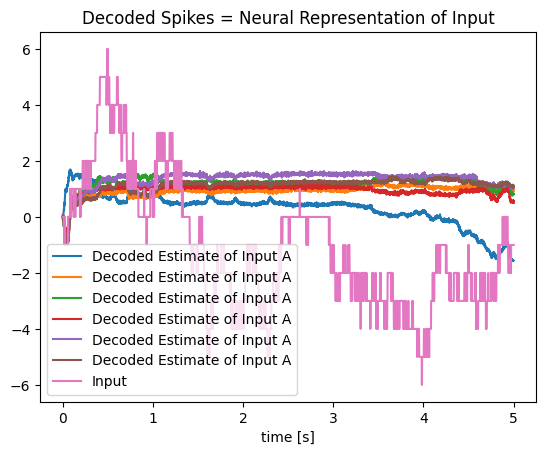

In [9]:
# Plot the input signals and decoded ensemble values
plt.figure()
plt.plot(
    sim.trange(), sim.data[input_probe_neuron], label="Decoded Estimate of Input A"
)
# Plot each probe
plt.plot(sim.trange(), sim.data[input_probe_node], label="Input")
plt.legend()
plt.xlabel("time [s]")
plt.title("Decoded Spikes = Neural Representation of Input")

In [10]:
"""def kalman_filter(A, B, H, Q, R, x0, P0, measurements):

    
    Parameters:
        A: State transition matrix
        B: Control input matrix
        H: Observation matrix
        Q: Process noise covariance matrix
        R: Measurement noise covariance matrix
        x0: Initial state estimate
        P0: Initial error covariance matrix
        measurements: Array of measurements
    
    Returns:
        array: Filtered state estimates
    
    n = A.shape[0]  # State vector size
    m = len(measurements)  # Number of measurements
    
    # Initialize variables
    x = x0
    P = P0
    filtered_states = []
    
    for measurement in measurements:
        # Predict
        x = A.dot(x)                            #state transition
        P = A.dot(P).dot(A.T) + Q               #covariance extrapolation
        
        # Update
        y = measurement - H.dot(x)              #interior of state update
        S = H.dot(P).dot(H.T) + R               #interior of Kalman Gain
        K = P.dot(H.T).dot(np.linalg.inv(S))    #Kalman Gain
        x = x + K.dot(y)                        #state update
        P = (np.eye(n) - K.dot(H)).dot(P)       #covariance update
        
        filtered_states.append(x)
        
    return np.array(filtered_states)

# Example 
# Define system matrices
A = np.array([[1, 1],
              [0, 1]])
B = np.eye(2)  # Assume no control input
H = np.array([[1, 0]])
Q = np.eye(2) * 0.1
R = np.array([[0.1]])
x0 = np.array([0, 0])
P0 = np.eye(2) * 10

measurements = np.array([1, 2, 3, 4, 5]) #example

# Perform Kalman filtering
filtered_states = kalman_filter(A, B, H, Q, R, x0, P0, measurements)

print("Filtered states:")
print(filtered_states)"""

'def kalman_filter(A, B, H, Q, R, x0, P0, measurements):\n\n    \n    Parameters:\n        A: State transition matrix\n        B: Control input matrix\n        H: Observation matrix\n        Q: Process noise covariance matrix\n        R: Measurement noise covariance matrix\n        x0: Initial state estimate\n        P0: Initial error covariance matrix\n        measurements: Array of measurements\n    \n    Returns:\n        array: Filtered state estimates\n    \n    n = A.shape[0]  # State vector size\n    m = len(measurements)  # Number of measurements\n    \n    # Initialize variables\n    x = x0\n    P = P0\n    filtered_states = []\n    \n    for measurement in measurements:\n        # Predict\n        x = A.dot(x)                            #state transition\n        P = A.dot(P).dot(A.T) + Q               #covariance extrapolation\n        \n        # Update\n        y = measurement - H.dot(x)              #interior of state update\n        S = H.dot(P).dot(H.T) + R             

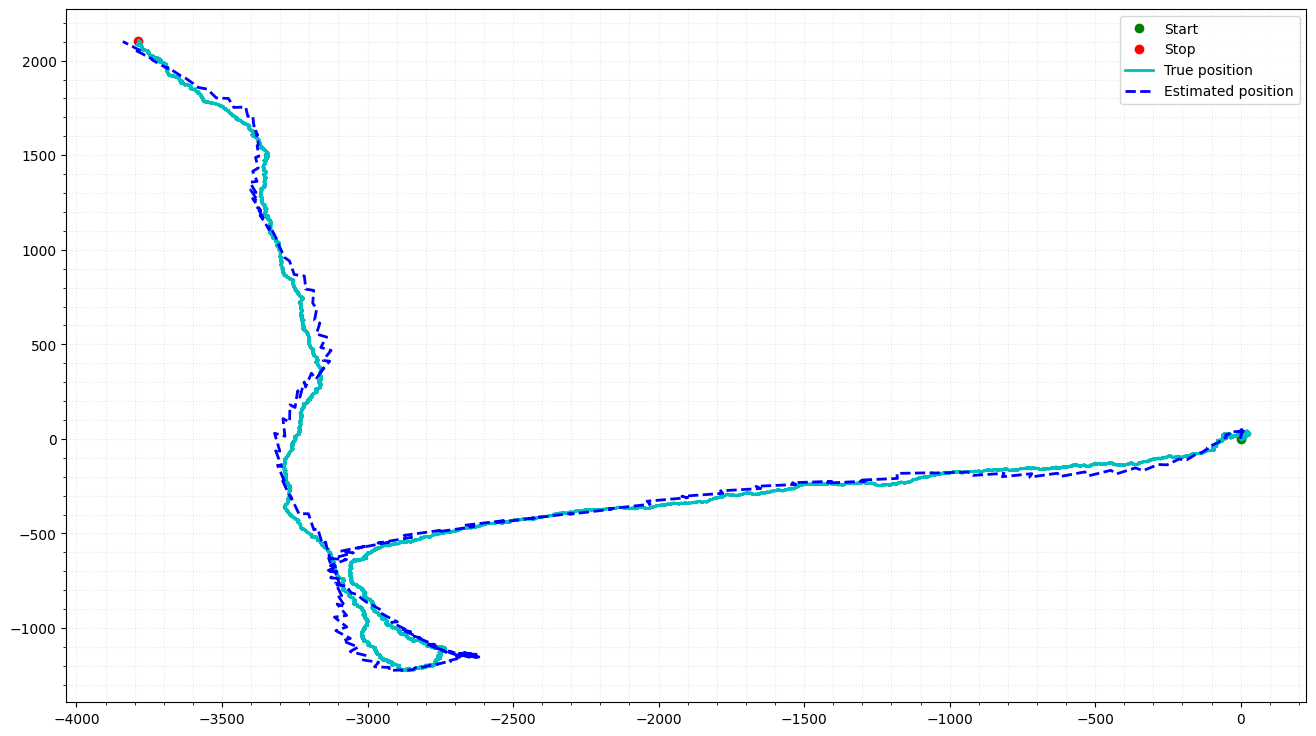

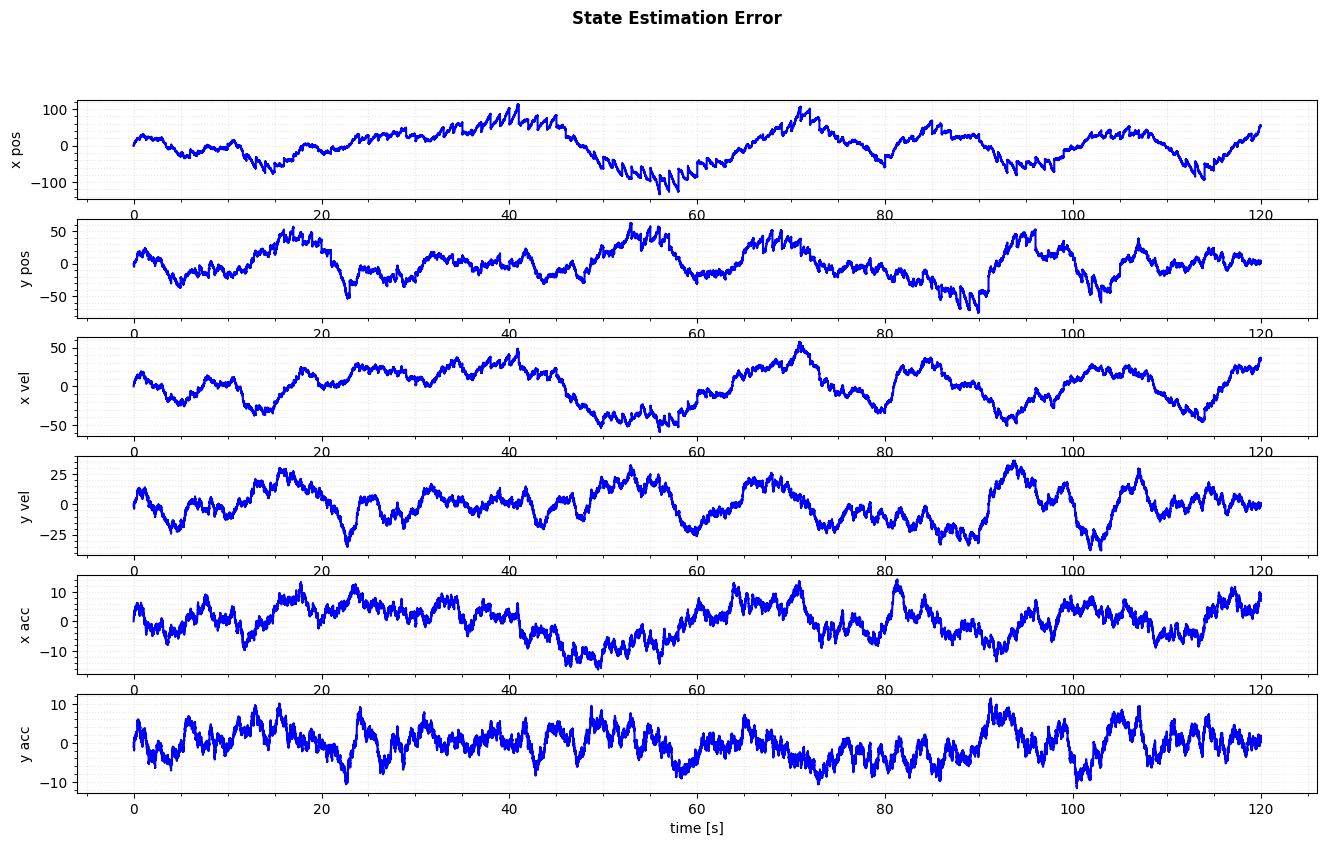

In [11]:
"""
This script runs an example Kalman filter using truth data from a CSV.
Written by Juan Jurado, DFEC
"""

import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt


# This function helps us go from continuous time to discrete time
def generate_qd(
    a_mtrx: np.array, b_mtrx: np.array, g_mtrx: np.array, delta_time: float
) -> np.array:
    ns = a_mtrx.shape[0]

    a = np.zeros((2 * ns, 2 * ns))
    a[0:ns, 0:ns] = -1 * a_mtrx
    a[ns : 2 * ns, ns : 2 * ns] = a_mtrx.T
    a[0:ns, ns : 2 * ns] = b_mtrx @ g_mtrx @ b_mtrx.T
    a = a * delta_time

    b = sp.linalg.expm(a)

    b12 = b[0:ns, ns : 2 * ns]
    b22 = b[ns : 2 * ns, ns : 2 * ns]

    qd_mtrx = b22.T @ b12

    return qd_mtrx


# Set up KF dynamics model
# 2D Constant acceleration model
a_matrix = np.array(
    [
        [0, 0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
    ]
)

# We are assuming constant acceleration between measurements so this b matrix will help us specify uncertainty
# in the acceleration dot states
b_matrix = np.array([[0, 0], [0, 0], [0, 0], [0, 0], [1, 0], [0, 1]])

# Specify uncertainty in the assumption of constant acceleration (units are complicated but basically
# squared acceleration dot units, so: ((m/s^2) / s)^2 = m^2/s^6
q_matrix = np.array([[0.2**2, 0], [0, 0.2**2]])

# Now discretize the dynamics model (Not sure if we need this part in nengo
dt = 0.001
phi_matrix = sp.linalg.expm(a_matrix * dt)
qd_matrix = generate_qd(a_matrix, b_matrix, q_matrix, dt)

# Set up KF measurement model
# This is a 2 x 6 to produce a 2D position measurement z = Hx where z is 2x1 and x is 6x1
meas_matrix = np.array([[1, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0]])
# This is a 2 x 2 to specify the covariance (uncertainty) in the GPS position measurements (in meters squared)
meas_uncertainty = np.array([[10**2, 0], [0, 10**2]])
# How often do we want to update with GPS position measurements?
meas_interval = 1  # seconds

# Import data
filename = "kf_true_trajectory 2.csv"
df = pd.read_csv(filename).set_index("t")

# Initialize states and uncertainty
state = df.loc[0].to_numpy()
covariance = np.eye(state.shape[0])

# Initialize containers for saving outputs
times = df.index.to_numpy()
true_state_history = [state]
state_history = [state]
covariance_history = [covariance]

# Run the simulation
# Run the sim for the remaining time after time 0
for time in times[1:]:
    true_state = df.loc[time].to_numpy()

    # Propagate the state using dynamics (@ is matrix multiplication in Python)
    state = phi_matrix @ state
    covariance = phi_matrix @ covariance @ phi_matrix.T + qd_matrix

    # If there is a measurement at this time, generate a simulated measurement and update
    if (time % meas_interval) < 1e-4:
        # Generate simulated noisy 2x1 measurement from the true state
        measurement = (meas_matrix @ true_state) + sp.linalg.cholesky(
            meas_uncertainty.T
        ) @ np.random.randn(
            2
        )  # make w/ neuron

        # Apply KF update equations
        # r = z - Hx
        residual = measurement - (meas_matrix @ state)
        # k = PH^T * (HPH^T)^-1
        kalman_gain = covariance @ (
            meas_matrix.T
            @ np.linalg.inv(meas_matrix @ covariance @ meas_matrix.T + meas_uncertainty)
        )

        # x_plus = x_minus + Kr
        state = state + (kalman_gain @ residual)
        # P_plus = P_minus - kHP
        covariance = covariance - kalman_gain @ (meas_matrix @ covariance)

    # Record history
    true_state_history.append(true_state)
    state_history.append(state)
    covariance_history.append(covariance)

# Plot results
true_state_history = np.array(true_state_history)
state_history = np.array(state_history)
covariance_history = np.array(covariance_history)

# First, plot God's Eye View of overall position trajectory
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)
ax.plot(true_state_history[0, 0], true_state_history[0, 1], "go", label="Start")
ax.plot(true_state_history[-1, 0], true_state_history[-1, 1], "ro", label="Stop")
ax.plot(
    true_state_history[:, 0],
    true_state_history[:, 1],
    "c-",
    label="True position",
    linewidth=2,
)
ax.plot(
    state_history[:, 0],
    state_history[:, 1],
    "b--",
    label="Estimated position",
    linewidth=2,
)
ax.legend()
ax.grid(which="minor", alpha=0.3, linestyle=":")
ax.grid(which="major", alpha=0.3, linestyle=":")
ax.minorticks_on()
plt.show()
ax.set_title("Kalman Filter Example", fontweight="bold")
ax.set_xlabel("x position [m]")
ax.set_ylabel("y position [m]")

# Now plot the error (true - estimated) for each state vs. time
fig = plt.figure(figsize=(16, 9))
fig.suptitle("State Estimation Error", fontweight="bold")
state_names = ["x pos", "y pos", "x vel", "y vel", "x acc", "y acc"]
for count, label in enumerate(state_names):
    ax = fig.add_subplot(6, 1, count + 1)
    error = true_state_history[:, count] - state_history[:, count]
    ax.plot(times, error, "b-")
    ax.set_ylabel(label)
    ax.grid(which="minor", alpha=0.3, linestyle=":")
    ax.grid(which="major", alpha=0.3, linestyle=":")
    ax.minorticks_on()
    if count == (len(state) - 1):
        ax.set_xlabel("time [s]")

In [140]:
# Model sensor data computation in nengo
# Create a class that multiplies the H matrix with the position data and adds noise
class SensorData:
    def __init__(self, new_position_data):
        self.new_position_data = new_position_data

    def step(self, t, x):
        # index = int(t / dt) % self.new_position_data.shape[0]
        current_loc = self.new_position_data[int(t)]
        meas_matrix = np.array([[1, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0]])

        # Compute the measurement by multiplying meas_matrix with current_loc
        mult_out = np.dot(
            meas_matrix, current_loc
        )  # .flatten()  # Flatten the output to ensure it's a 1D array
        return mult_out + (sp.linalg.cholesky(meas_uncertainty.T) @ np.random.randn(2))


sensorData = SensorData(true_state_history)
print(sensorData)

In [142]:
# Model this
with model:

    # Make a node for step data
    mult_node = nengo.Node(sensorData.step, size_in=6, size_out=2)
    # Create ensemble for the output data
    mult_neuron = nengo.Ensemble(n_neurons=100, dimensions=2)
    # Connect node to neuron
    mult_conn = nengo.Connection(mult_node, mult_neuron)
    # Probe the node
    mult_probe = nengo.Probe(mult_node)
    # Probe the neuron
    mult_probe_neuron = nengo.Probe(mult_neuron, synapse=0.01)

# with nengo.Simulator(model) as sim:
#    sim.run(120)

In [ ]:
# FOR FINAL CHECKPOINT
# Plot results
"""neuron_true_state_history = np.array(neuron_true_state_history)
neuron_state_history = np.array(neuron_state_history)
neuron_covariance_history = np.array(neuron_covariance_history)

# First, plot God's Eye View of overall position trajectory
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)
ax.plot(neuron_true_state_history[0, 0], neuron_true_state_history[0, 1], 'go', label='Start')
ax.plot(neuron_true_state_history[-1, 0], neuron_true_state_history[-1, 1], 'ro', label='Stop')
ax.plot(neuron_true_state_history[:, 0], neuron_true_state_history[:, 1], 'c-', label='True position', linewidth=2)
ax.plot(neuron_state_history[:, 0], neuron_state_history[:, 1], 'b--', label='Estimated position', linewidth=2)
ax.legend()
ax.grid(which='minor', alpha=0.3, linestyle=":")
ax.grid(which='major', alpha=0.3, linestyle=":")
ax.minorticks_on()
plt.show()
ax.set_title('Kalman Filter Example', fontweight='bold')
ax.set_xlabel('x position [m]')
ax.set_ylabel('y position [m]')

# Now plot the error (true - estimated) for each state vs. time
fig = plt.figure(figsize=(16, 9))
fig.suptitle('State Estimation Error', fontweight='bold')
state_names = ['x pos', 'y pos', 'x vel', 'y vel', 'x acc', 'y acc']
for count, label in enumerate(state_names):
    ax = fig.add_subplot(6, 1, count + 1)
    error = true_state_history[:, count] - state_history[:, count]
    ax.plot(times, error, 'b-')
    ax.set_ylabel(label)
    ax.grid(which='minor', alpha=0.3, linestyle=":")
    ax.grid(which='major', alpha=0.3, linestyle=":")
    ax.minorticks_on()
    if count == (len(state) - 1):
        ax.set_xlabel('time [s]')"""

In [38]:
"""with nengo.Network() as model:
    # Define ensembles to represent state estimate, error covariance, and measurements
    state_estimate = nengo.Ensemble(100, dimensions=2)
    error_covariance = nengo.Ensemble(100, dimensions=2)
    measurements = nengo.Node([0])
    
    # Function to perform Kalman filter update
    def kalman_filter_nengo(A, B, H, Q, R, x0, P0, measurements):

        
        Parameters:
            A: State transition matrix
            B: Control input matrix
            H: Observation matrix
            Q: Process noise covariance matrix
            R: Measurement noise covariance matrix
            x0: Initial state estimate
            P0: Initial error covariance matrix
            measurements: Array of measurements
        
        Returns:
            array: Filtered state estimates
        
        n = A.shape[0]  # State vector size
        m = len(measurements)  # Number of measurements
        
        # Initialize variables
        x = x0
        P = P0
        filtered_states = []
    
        for measurement in measurements:
            # Predict
            x = A.dot(x)                            #state transition
            P = A.dot(P).dot(A.T) + Q               #covariance extrapolation
            
            # Update
            y = measurement - H.dot(x)              #interior of state update
            S = H.dot(P).dot(H.T) + R               #interior of Kalman Gain
            K = P.dot(H.T).dot(np.linalg.inv(S))    #Kalman Gain
            x = x + K.dot(y)                        #state update
            P = (np.eye(n) - K.dot(H)).dot(P)       #covariance update
            
            filtered_states.append(x)
            
        return np.array(filtered_states)

    # Connect Kalman filter step function to the network
    kalman_node = nengo.Node(kalman_filter_nengo)
    nengo.Connection(state_estimate, kalman_node[0])
    #nengo.Connection(error_covariance, kalman_node[1])

    # Connect the output of the Kalman filter to the state estimate and error covariance ensembles
    nengo.Connection(kalman_node, state_estimate)
    #nengo.Connection(kalman_node[1], error_covariance)"""

ValidationError: Node.output: output function '<function kalman_filter_nengo at 0x0000023CA5304F70>' is expected to accept exactly 1 argument (time, as a float)